In [ ]:

!pip install ultralytics --quiet
!pip install seaborn --quiet


In [ ]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import pandas as pd
from PIL import Image
import os, shutil
from ultralytics import YOLO


data_train_features_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_train.pkl'
data_train_labels_url   = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/y_train.pkl'
data_test_features_url  = 'https://www.raphaelcousin.com/modules/data-science-practice/module7/exercise/X_test.pkl'

def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name}')


download_file(data_train_features_url, 'X_train.pkl')
download_file(data_train_labels_url, 'y_train.pkl')
download_file(data_test_features_url, 'X_test.pkl')


with open('X_train.pkl', 'rb') as f:
    X = pickle.load(f)

with open('y_train.pkl', 'rb') as f:
    y = pickle.load(f)

with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

print(f"Loaded {len(X)} training images")
print(f"Sample image shape: {X[0].shape}")
print(f"Sample labels shape: {y[0].shape}")
print(f"Sample labels (YOLO format):\n{y[0]}")
print(f"Loaded {len(X_test)} test images")


Downloaded X_train.pkl
Downloaded y_train.pkl
Downloaded X_test.pkl
Loaded 496 training images
Sample image shape: (418, 466, 3)
Sample labels shape: (1, 5)
Sample labels (YOLO format):
[[          0     0.65987     0.57177     0.10944     0.16268]]
Loaded 125 test images


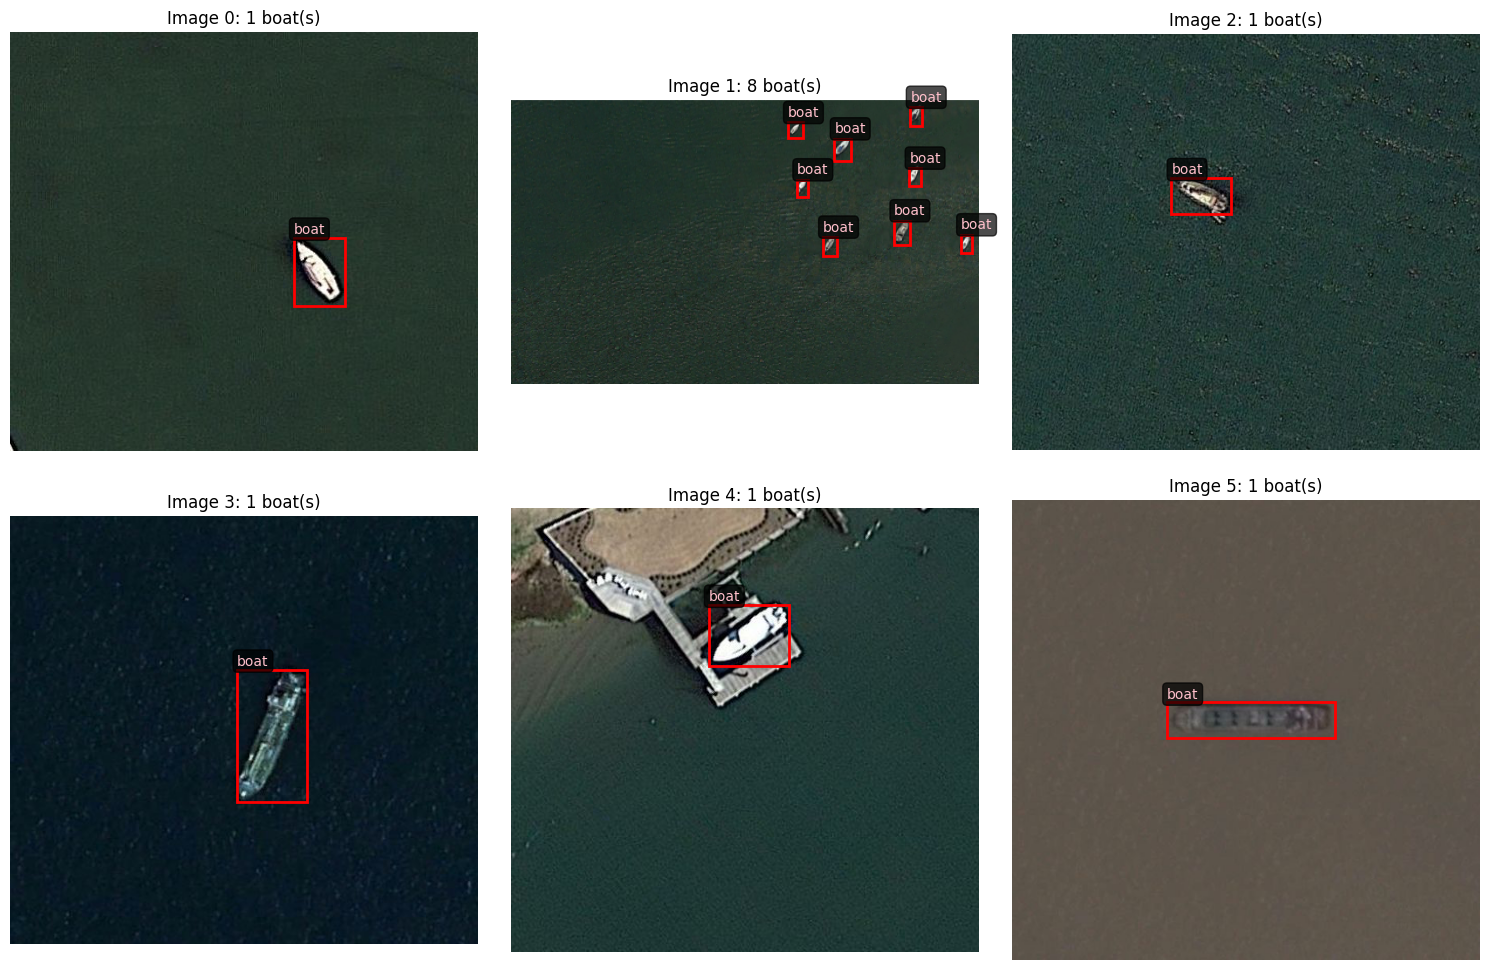

In [ ]:
def plot_image_with_boxes(image, boxes, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)
    height, width = image.shape[:2]
    for box in boxes:
        class_id, x_center, y_center, box_width, box_height = box
        x_center_px = x_center * width
        y_center_px = y_center * height
        box_width_px = box_width * width
        box_height_px = box_height * height
        x1 = x_center_px - box_width_px / 2
        y1 = y_center_px - box_height_px / 2
        rect = patches.Rectangle((x1, y1), box_width_px, box_height_px,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, 'boat', color='pink', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    ax.axis('off')
    return ax


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i in range(6):
    plot_image_with_boxes(X[i], y[i], ax=axes[i])
    axes[i].set_title(f'Image {i}: {len(y[i])} boat(s)')
plt.tight_layout()
plt.show()


In [ ]:
import os, shutil


if os.path.exists("boat_dataset"):
    shutil.rmtree("boat_dataset")
os.makedirs("boat_dataset/images/train", exist_ok=True)
os.makedirs("boat_dataset/labels/train", exist_ok=True)
os.makedirs("boat_dataset/images/val", exist_ok=True)
os.makedirs("boat_dataset/labels/val", exist_ok=True)


split_idx = int(0.8 * len(X))
X_train_split, y_train_split = X[:split_idx], y[:split_idx]
X_val_split, y_val_split = X[split_idx:], y[split_idx:]

def save_split(X_split, y_split, split_name):
    for i, (img, boxes) in enumerate(zip(X_split, y_split)):
        img_path = f"boat_dataset/images/{split_name}/{i}.jpg"
        label_path = f"boat_dataset/labels/{split_name}/{i}.txt"


        pil_img = Image.fromarray(img)
        if pil_img.mode == "RGBA":
            pil_img = pil_img.convert("RGB")

        pil_img.save(img_path)


        with open(label_path, "w") as f:
            for box in boxes:
                class_id, x_center, y_center, w, h = box
                f.write(f"{int(class_id)} {x_center} {y_center} {w} {h}\n")


save_split(X_train_split, y_train_split, "train")
save_split(X_val_split, y_val_split, "val")


dataset_path = os.path.abspath("boat_dataset")

with open("boat_dataset/data.yaml", "w") as f:
    f.write(
        f"train: {dataset_path}/images/train\n"
        f"val: {dataset_path}/images/val\n"
        "nc: 1\n"
        "names: ['boat']\n"
    )


print(f"Train images: {len(X_train_split)}, Val images: {len(X_val_split)}")
print("Contenu data.yaml :")
print(open("boat_dataset/data.yaml").read())


Train images: 396, Val images: 100
Contenu data.yaml :
train: /content/boat_dataset/images/train
val: /content/boat_dataset/images/val
nc: 1
names: ['boat']



In [ ]:
model = YOLO('yolov8s.pt')



results = model.train(
    data="boat_dataset/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    lr0=5e-4,
    patience=10,
    device=0
)




Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pr

In [ ]:
val_results = model.val(data="boat_dataset/data.yaml", imgsz=640, split="val")

print("resultats validation locale:")
print(f"mAP50:    {val_results.box.map50:.3f}")



Ultralytics 8.3.213 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 592.1±178.3 MB/s, size: 15.2 KB)
val: Scanning /content/boat_dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 183.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.7it/s 2.6s
                   all        100        245      0.861      0.706      0.786      0.493
Speed: 3.3ms preprocess, 13.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/runs/detect/val3
resultats validation locale:
mAP50:    0.786


In [ ]:


predictions = []

for img_idx, img in enumerate(X_test):
    temp_img = Image.fromarray(img)
    if temp_img.mode == "RGBA":
        temp_img = temp_img.convert("RGB")
    temp_path = f"temp_{img_idx}.jpg"
    temp_img.save(temp_path)

    results = model.predict(source=temp_path, conf=0.25, verbose=False)

    for box_idx, box in enumerate(results[0].boxes):
        x_center, y_center, width, height = box.xywhn[0].cpu().numpy()
        confidence = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        predictions.append({
            'image_id': img_idx,
            'box_idx': box_idx,
            'class_id': 0,
            'confidence': float(confidence),
            'x_center': float(x_center),
            'y_center': float(y_center),
            'width': float(width),
            'height': float(height)
        })

    if (img_idx+1) % 10 == 0:
        print(f"Processed {img_idx+1}/{len(X_test)} images")

df_predictions = pd.DataFrame(predictions)
df_predictions.to_csv('predictions.csv', index=False)




Processed 10/125 images
Processed 20/125 images
Processed 30/125 images
Processed 40/125 images
Processed 50/125 images
Processed 60/125 images
Processed 70/125 images
Processed 80/125 images
Processed 90/125 images
Processed 100/125 images
Processed 110/125 images
Processed 120/125 images
